### Loading the libraries

In [1]:
#for importing the data
from pathlib import Path
from numpy import loadtxt

# for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import IsolationForest

# for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

### Loading the data from Kaggle

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 149MB/s]


In [6]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [7]:
# LOAD THE CSV dataset into a pandas dataframe
df = pd.read_csv('AB_NYC_2019.csv')

### Data Cleaning and Transformation

In [9]:
print('number of rows in the dataset:', len(df))
df.head()

number of rows in the dataset: 48895


id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [10]:
### Statistical indicators for each column
df.describe()

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [11]:
## Check presence of rows with null values
df.isna().any()

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [12]:
# Replace all NaN values in 'reviews_per_month' with 0
df.fillna({'reviews_per_month':0}, inplace=True)

In [13]:
# Remove non-interesting for our target: name, host_name, host_id, last_review
df=df.drop(['name','host_name',	'last_review', 'host_id','id'], axis=1)

In [14]:
df.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [15]:
# ONE-HOT ENCODING on the columns 'neighbourhood_group' and 'room_type' because they contain categorical values ( feature hashing for neighbourhood)
df_3 = pd.get_dummies(df, columns=['room_type','neighbourhood_group'])

In [16]:
#  FEATURE HASHING to encode 215 values of column neighbourhood in 3 columns

# Create a FeatureHasher object with the desired number of output columns
hasher = FeatureHasher(n_features=3, input_type='string')
hashed = hasher.transform(df_3['neighbourhood'].apply(lambda x: [x]))
hashed_df = pd.DataFrame.sparse.from_spmatrix(hashed, columns=['neighbourhood_1', 'neighbourhood_2','neighbourhood_3'])

# Concatenate the hashed columns back onto the original DataFrame
df_3 = pd.concat([df_3, hashed_df], axis=1)

# Drop the original column, since it has been hashed
df_3.drop('neighbourhood', axis=1, inplace=True)

In [17]:
df_3.head()

latitude  longitude  price  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237    149               1                  9   
1  40.75362  -73.98377    225               1                 45   
2  40.80902  -73.94190    150               3                  0   
3  40.68514  -73.95976     89               1                270   
4  40.79851  -73.94399     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          0                       1                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          1                       0                      0   
4                          1                       0                      0   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          0                             1   
4                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_Staten Island  neighbourhood_1  neighbourhood_2  \
0                                  0              0.0              0.0   
1                                  0              0.0              0.0   
2                                  0             -1.0              0.0   
3                                  0              1.0              0.0   
4                                  0              0.0              0.0   

   neighbourhood_3  
0              1.0  
1              1.0  
2              0.0  
3              0.0  
4              1.0

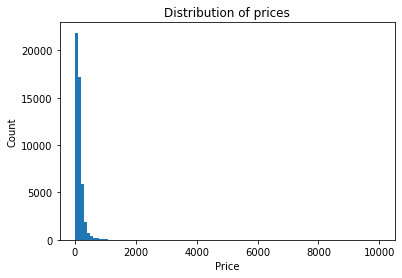

In [18]:
### Function to display distribution of prices

def visual_price(df) :   

    # create a histogram of the "price" variable
    plt.hist(df['price'], bins=100)
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.title('Distribution of prices')
    plt.show()

    # create a boxplot of the "price" variable
    plt.boxplot(df['price'])
    plt.ylabel('Price')
    plt.title('Boxplot of prices')
    plt.show()

####

visual_price(df_3)

In [19]:
### ISOLATION FOREST to detect outliers

# Select the column for outlier detection
column_name = 'price'

# Extract the column data as a numpy array
data = df_3[column_name].values.reshape(-1, 1)

# Create an instance of the IsolationForest class
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.03, random_state=42)

# Fit the model to the column data
model.fit(data)

IsolationForest(contamination=0.03, random_state=42)

In [20]:
### DEFINE OUTLIERS: points detected by Isolation Forest or with price < 10

# Predict the outlier status for each data point in the column
outliers = model.predict(data)

# Identify the outlier rows in the dataframe
outlier_rows = df_3[(outliers == -1) | (df_3['price'] < 10)]

# Print the proportion of outliers in dataset
print('Outlier rate in dataset:', round(len(outlier_rows['price'])/len(df)*100),'%')

### Characteristics of outliers
outlier_rows['price'].describe()

Outlier rate in dataset: 3 %


count     1448.000000
mean       944.014503
std       1040.425135
min          0.000000
25%        500.000000
50%        650.000000
75%        900.000000
max      10000.000000
Name: price, dtype: float64

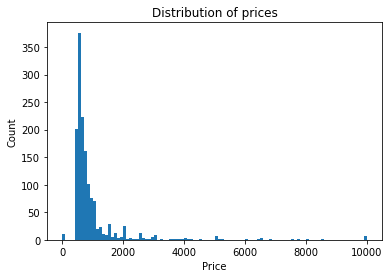

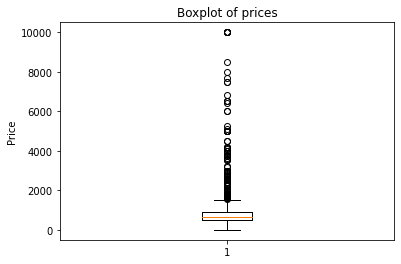

In [21]:
## Histogram of outliers
visual_price(outlier_rows)

In [22]:
### REMOVE OUTLIERS to get our final dataset
df_cleaned = df_3[(outliers == 1) & (df_3['price'] > 10)]

In [23]:
print('number of rows in cleaned dataset:',len(df_cleaned))

number of rows in cleaned dataset: 47430


In [24]:
df_cleaned.head()

latitude  longitude  price  minimum_nights  number_of_reviews  \
0  40.64749  -73.97237    149               1                  9   
1  40.75362  -73.98377    225               1                 45   
2  40.80902  -73.94190    150               3                  0   
3  40.68514  -73.95976     89               1                270   
4  40.79851  -73.94399     80              10                  9   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6               365   
1               0.38                               2               355   
2               0.00                               1               365   
3               4.64                               1               194   
4               0.10                               1                 0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          0                       1                      0   
1                          1                       0                      0   
2                          0                       1                      0   
3                          1                       0                      0   
4                          1                       0                      0   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          0                             1   
4                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_Staten Island  neighbourhood_1  neighbourhood_2  \
0                                  0              0.0              0.0   
1                                  0              0.0              0.0   
2                                  0             -1.0              0.0   
3                                  0              1.0              0.0   
4                                  0              0.0              0.0   

   neighbourhood_3  
0              1.0  
1              1.0  
2              0.0  
3              0.0  
4              1.0

In [25]:
### Columns and their types of cleaned dataset
df_cleaned.dtypes

latitude                                        float64
longitude                                       float64
price                                             int64
minimum_nights                                    int64
number_of_reviews                                 int64
reviews_per_month                               float64
calculated_host_listings_count                    int64
availability_365                                  int64
room_type_Entire home/apt                         uint8
room_type_Private room                            uint8
room_type_Shared room                             uint8
neighbourhood_group_Bronx                         uint8
neighbourhood_group_Brooklyn                      uint8
neighbourhood_group_Manhattan                     uint8
neighbourhood_group_Queens                        uint8
neighbourhood_group_Staten Island                 uint8
neighbourhood_1                      Sparse[float64, 0]
neighbourhood_2                      Sparse[floa

In [26]:
## Check presence of null values in rows of clean dataset
df_cleaned.isnull().any()

latitude                             False
longitude                            False
price                                False
minimum_nights                       False
number_of_reviews                    False
reviews_per_month                    False
calculated_host_listings_count       False
availability_365                     False
room_type_Entire home/apt            False
room_type_Private room               False
room_type_Shared room                False
neighbourhood_group_Bronx            False
neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan        False
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
neighbourhood_1                      False
neighbourhood_2                      False
neighbourhood_3                      False
dtype: bool

In [27]:
# Distribution price visualisation after pre-processing data
visual_price(df_cleaned)

### Defining the base ensemble models

#### Split data

In [28]:
X=df_cleaned.drop('price', axis=1)
y=df_cleaned['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Features importance function

In [29]:
def important_features(model, X):
  importances=model.feature_importances_
  df_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

  # Ordering by decreasing order
  df_importances = df_importances.sort_values('importance', ascending=False).reset_index(drop=True)

  # Barplot
  plt.figure(figsize=(10, 6))
  plt.bar(df_importances['feature'], df_importances['importance'])
  plt.xticks(rotation=90)
  plt.ylabel('Importance')
  plt.show()

  # Sélectionner les variables les plus importantes (par exemple, les 5 premières)
  top_features = df_importances['feature'][:5].tolist()
  print('Top features:', top_features)

#### Storing model performance

We will store model performance in a dictionnary to be able to compare models later.

In [42]:
summary = {
    'model': [],
    'runtime': [],
    'rmse': [],
    'r2': []
}

#### Decision Tree

In [43]:
print("Decision Tree Regressor:\n")

# call & fit the model 
dt = DecisionTreeRegressor(random_state=42,max_depth= 8, min_samples_leaf= 14, min_samples_split=2)

start_time = time.time()
dt.fit(X_train, y_train)

# predictions on test set
y_pred = dt.predict(X_test)
end_time = time.time()

# RMSE and R^2 for evaluation
dt_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
dt_r2 = round(r2_score(y_test, y_pred),2)


print("RMSE: ", dt_rmse)
print("R^2: ", dt_r2)

summary['model'].append("Decision Tree Regressor")
summary['runtime'].append(round(end_time - start_time, 4))
summary['rmse'].append(dt_rmse)
summary['r2'].append(dt_r2)

Decision Tree Regressor:

RMSE:  58.58
R^2:  0.49


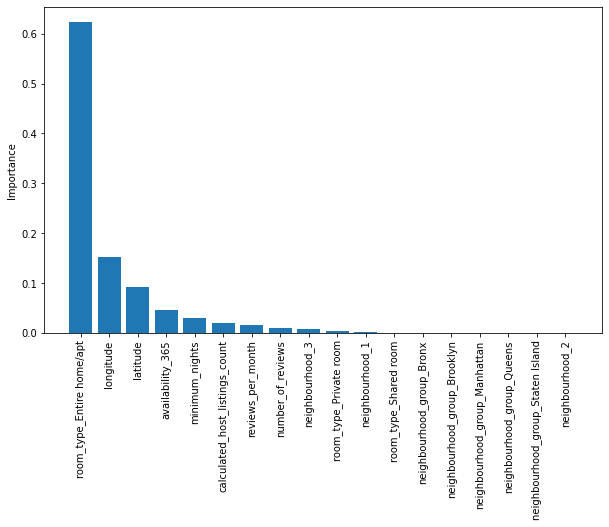

Top features: ['room_type_Entire home/apt', 'longitude', 'latitude', 'availability_365', 'minimum_nights']


In [45]:
# FEATURES IMPORTANCES
important_features(dt, X)

#### Bagging

##### Random Forest

In [46]:
print("Random Forest Regressor:\n")

# RANDOM FOREST with best model params
rf = RandomForestRegressor(n_estimators=400, max_depth = 50, min_samples_split = 4,min_samples_leaf =5,max_features='sqrt', bootstrap = True, random_state=42)

start_time = time.time()
rf.fit(X_train, y_train)

## Predictions on test dataset
y_pred=rf.predict(X_test)
end_time = time.time()

# RMSE and R^2 for evaluation
rf_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
rf_r2 = round(r2_score(y_test, y_pred),2)

print("RMSE: ", rf_rmse)
print("R^2: ", rf_r2)

summary['model'].append("Random Forest Regressor")
summary['runtime'].append(round(end_time - start_time, 4))
summary['rmse'].append(rf_rmse)
summary['r2'].append(rf_r2)

Random Forest Regressor:

RMSE:  55.43
R^2:  0.55


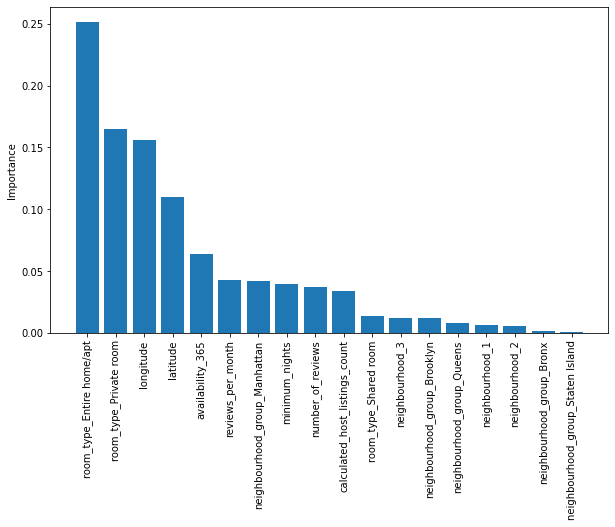

Top features: ['room_type_Entire home/apt', 'room_type_Private room', 'longitude', 'latitude', 'availability_365']


In [33]:
# Feature importance
important_features(rf, X)

It is interesting to observe that with random forest, there are more features with importance than for the decision tree, that focuses mainly on room type.

#### Boosting

##### Extreme Gradient Boosting (XGBoost)

In [48]:
print("Extreme Gradient Boosting Regressor: \n")

#call the model with the best parameters
xgboost = xgb.XGBRegressor(
                max_depth = 10,
                min_child_weight = 0,
                reg_alpha = 3,
                reg_lambda  = 1.5,
                subsample = 0.9,
                gamma = 0,
                max_delta_step = 0,
                max_leaves = 0,
                colsample_bytree = 0.55,
                learning_rate = 0.045,
                max_bin = 300,
                n_estimators = 140,
                scale_pos_weight = 0,
                random_state = 42)

start_time = time.time()
xgboost.fit(X_train, y_train)

## Predictions on test dataset
y_pred=xgboost.predict(X_test)
end_time = time.time()

# RMSE and R^2 for evaluation
xgb_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
xgb_r2 = round(r2_score(y_test, y_pred),2)

print("RMSE: ", xgb_rmse)
print("R^2: ", xgb_r2)

summary['model'].append("Extreme Gradient Boosting Regressor")
summary['runtime'].append(round(end_time - start_time, 4))
summary['rmse'].append(xgb_rmse)
summary['r2'].append(xgb_r2)

Extreme Gradient Boosting Regressor: 

RMSE:  55.12
R^2:  0.55


In [35]:
# Features importance
important_features(xgboost, X)

Top features: ['room_type_Entire home/apt', 'room_type_Private room', 'neighbourhood_group_Manhattan', 'room_type_Shared room', 'neighbourhood_group_Queens']


##### Adaboost

In [50]:
print("AdaBoost Regressor: \n")

# Initialize the model
adaboost = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth = 5, min_samples_split = 4, min_samples_leaf = 12),
                             n_estimators=50,
                             learning_rate=0.01,
                             loss = 'linear',
                             random_state=42)

# Fit the model to the training data
start_time = time.time()
adaboost.fit(X_train, y_train)

# Evaluate the performance of the model on the testing data
y_pred = adaboost.predict(X_test)
end_time = time.time()

# RMSE and R^2 for evaluation
ada_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
ada_r2 = round(r2_score(y_test, y_pred),2)

print("RMSE: ", ada_rmse)
print("R^2: ", ada_r2)

summary['model'].append("AdaBoost Regressor")
summary['runtime'].append(round(end_time - start_time, 4))
summary['rmse'].append(ada_rmse)
summary['r2'].append(ada_r2)

AdaBoost Regressor: 

RMSE:  59.79
R^2:  0.47


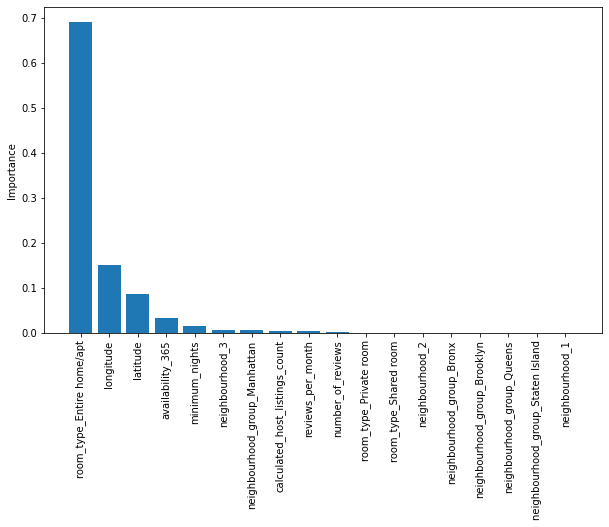

Top features: ['room_type_Entire home/apt', 'longitude', 'latitude', 'availability_365', 'minimum_nights']


In [37]:
# Features importance
important_features(adaboost, X)

### Building the stacked model

In [52]:
base_models = [
    ('Decision Tree Regressor', dt),

    ('Random Forest Regressor', rf),

    ('Extreme Gradient Boosting Regressor', xgboost),
               
    ('AdaBoost Regressor', adaboost)
    ]

stacked = StackingRegressor(
    estimators = base_models,
    final_estimator = LinearRegression(),
    cv = 5)

### Runing the base and stacked models

In [57]:
print("Stacked Ensembles:\n")

start_time = time.time()
stacked.fit(X_train, y_train)    

y_pred = stacked.predict(X_test)
end_time = time.time()

stacked_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
stacked_r2 = round(r2_score(y_test, y_pred),2)

print("RMSE: ", stacked_rmse)
print("R^2: ", stacked_r2)

summary['model'].append("Stacked Ensembles")
summary['runtime'].append(round(end_time - start_time, 4))
summary['rmse'].append(stacked_rmse)
summary['r2'].append(stacked_r2)

Stacked Ensembles:

RMSE:  54.91
R^2:  0.56


### Summary dataframe

In [59]:
conclusion = pd.DataFrame.from_dict(summary)
conclusion

model   runtime   rmse    r2
0              Decision Tree Regressor    0.1651  58.58  0.49
1              Random Forest Regressor   33.4620  55.43  0.55
2  Extreme Gradient Boosting Regressor   22.1223  55.12  0.55
3                   AdaBoost Regressor    6.7798  59.79  0.47
4                    Stacked Ensembles  211.6048  54.91  0.56

### Conclusion

Out of the individually tested model, XGBoost is the one that works best on our clean Airbnb data, closely follwed by Random Forest. It is not surprising that these two models show the best performance. Indeed, they respectively use boosting and bagging techniques to improve the prediction compared to a single decision tree. They reduce the variance and the bias. Adaboost shows the worst performance, which is not very surprising given that this model does not handle outliers well. In fact, although we have put some effort into eliminating unusual observations, the data remains unbalanced. Finally, stacking the models gives the best performance, but it does not represent an impressive improvement (indeed, we are able to reach 54.4 of RMSE, vs 55.1 for XGBoost). It is also important to notice that additionnally, the computation time for the stacked ensembles model is much longer than for the other models.